# Model annealing
Infer a cosmological model via Continuous Tempering Langevin. 

In [1]:
!python -c "import jax; print(jax.default_backend(), jax.devices())"
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.35' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots, MCSamples

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Continuous Tempering Langevin")
from montecosmo.utils import pickle_dump, pickle_load
save_directory = os.path.expanduser("~/scratch/pickles/")

gpu [cuda(id=0)]


2024-02-05 10:18:51.029794: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Import and simulate fiducial

In [2]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator
from montecosmo.models import model_config as config
# Build model
config.update(scale_factor_lpt=0.5, mesh_size=64*np.ones(3, dtype=int))
print(f"{config=}")
model = partial(pmrsd_model, **config)

# Get latent variables and fix cosmological parameters
cosmo_names = ['Omega_c', 'sigma8']
cosmo_labels = [r'\Omega_c', r'\sigma_8']

# Get fiducial parameters
# cond_params = {cosmo_name+'_':0. for cosmo_name in cosmo_names+['b1','b2','bs','bnl']}
cond_params = {cosmo_name+'_':0. for cosmo_name in cosmo_names}
fiduc_params = get_simulator(condition(partial(model, trace_deterministic=True), cond_params))(rng_seed=0)
# fiduc_cosmo = {name: fiduc_params[name] for name in cosmo_names}

# Condition model on observables
obs_names = ['obs_mesh','Omega_c_','sigma8_','b1_','b2_','bs_','bnl_']
obs_params = {name: fiduc_params[name] for name in obs_names}
obs_params.update(obs_mesh=fiduc_params['biased_mesh'])
observed_model = condition(model, obs_params)
score_fn = get_score_fn(observed_model)

config={'mesh_size': array([64, 64, 64]), 'box_size': array([640., 640., 640.]), 'scale_factor_lpt': 0.5, 'scale_factor_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_deterministic': False}


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


## Init diffusion

In [36]:
from diffrax import diffeqsolve, ControlTerm, WeaklyDiagonalControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree
from jax import eval_shape

def get_run_langevin(t0, t1, dt0, ts, score_fn, noise_fn, shape_struct):
    drift = lambda t, y, args: score_fn(y, model_kwargs={'noise':noise_fn(t)})
    diffusion = lambda t, y, args: tree_map(lambda x: 2**.5 * jnp.ones_like(x), y)
    solver = Euler()
    saveat = SaveAt(ts=ts)

    @jit
    @vmap
    def run_langevin(y, seed):
        brownian_motion = VirtualBrownianTree(t0, t1, tol=jnp.abs(dt0)/10, shape=shape_struct, key=seed)
        terms = MultiTerm(ODETerm(drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))
        return diffeqsolve(terms, solver, t0, t1, dt0=dt0, y0=y, max_steps=10_000, saveat=saveat).ys
    
    return run_langevin

init_simulator = jit(vmap(get_simulator(condition(partial(prior_model, **config), cond_params))))
sample_key, diffeq_key = jr.split(jr.PRNGKey(43), 2)
n_samples = 3
init_params = init_simulator(jr.split(sample_key, n_samples))
init_params = {name: init_params[name] for name in ['init_mesh_']}
shape_struct = eval_shape(lambda x: tree_map(lambda y:y[0], x), init_params)
t0, t1, dt0 = 0, 10, 1e-3
ts = jnp.linspace(t0,t1,11)

In [37]:
from jax.flatten_util import ravel_pytree
score_vfn = jit(vmap(score_fn))
scores = score_vfn(init_params, {'noise':jnp.ones(n_samples)})
score_flat = ravel_pytree(scores)[0]
jnp.min(score_flat)*dt0, jnp.max(score_flat)*dt0 # check if steps are not too big

(Array(-0.03878671, dtype=float32), Array(0.01754573, dtype=float32))

## Power spectrum convergence

In [38]:
mlflow.end_run()
mlflow.start_run(run_name="Pk0-1 conv strict + anim")
# mlflow.start_run(run_id="")
mlflow.log_params(config)
mlflow.log_params({'n_samples':n_samples,'t0':t0,'t1':t1,'dt0':dt0})

from montecosmo.models import get_pk_fn, get_init_mesh_fn
pk_init = get_pk_fn(config)(fiduc_params['init_mesh'])
pk_vfn = vmap(get_pk_fn(config))
init_mesh_vfn = vmap(get_init_mesh_fn(config))

### $P_0(k)$ to $P_0(k)$

In [6]:
from itertools import pairwise
current_params = dict(init_params)
params_ = tree_map(lambda x: jnp.broadcast_to(x, (n_samples,*jnp.shape(x))), obs_params)
params_.pop('obs_mesh')
noises = jnp.linspace(0,5,6)[::-1]
pks = np.zeros((n_samples, len(noises), len(ts), *pk_init.shape))
meshes = np.zeros((n_samples, len(noises), len(ts), *config['mesh_size']))

mlflow.log_metric('halt',0)
for i_noise, noise in enumerate(noises):
    noise_fn = lambda t: noise
    print(f"noise = {noise_fn(t0):.2f}. step = {i_noise+1}/{len(noises)}")
# for i_noise, (noise0, noise1) in enumerate(pairwise(noises)):
#     noise_fn = lambda t: (noise0-noise1)*(t-t1)/(t0-t1) + noise1
#     print(f"noise goes from {noise_fn(t0):.2f} to {noise_fn(t1):.2f}. step = {i_noise+1}/{len(noises)}")
    
    run_langevin = get_run_langevin(t0, t1, dt0, ts, score_fn, noise_fn, shape_struct)
    run = run_langevin(current_params, jr.split(diffeq_key, n_samples))
    current_params = tree_map(lambda x: x[:,-1], run)
    for i_time in range(len(ts)):
        _, init_mesh = init_mesh_vfn(**dict(params_, init_mesh_=run['init_mesh_'][:, i_time]))
        meshes[:, i_noise, i_time] = init_mesh
        pks[:, i_noise, i_time] = pk_vfn(init_mesh)
mlflow.log_metric('halt',1), mlflow.log_metric('halt',0);

noise goes from 5.00 to 4.00. step = 1/6


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


noise goes from 4.00 to 3.00. step = 2/6
noise goes from 3.00 to 2.00. step = 3/6
noise goes from 2.00 to 1.00. step = 4/6
noise goes from 1.00 to 0.00. step = 5/6


### Plot and animate

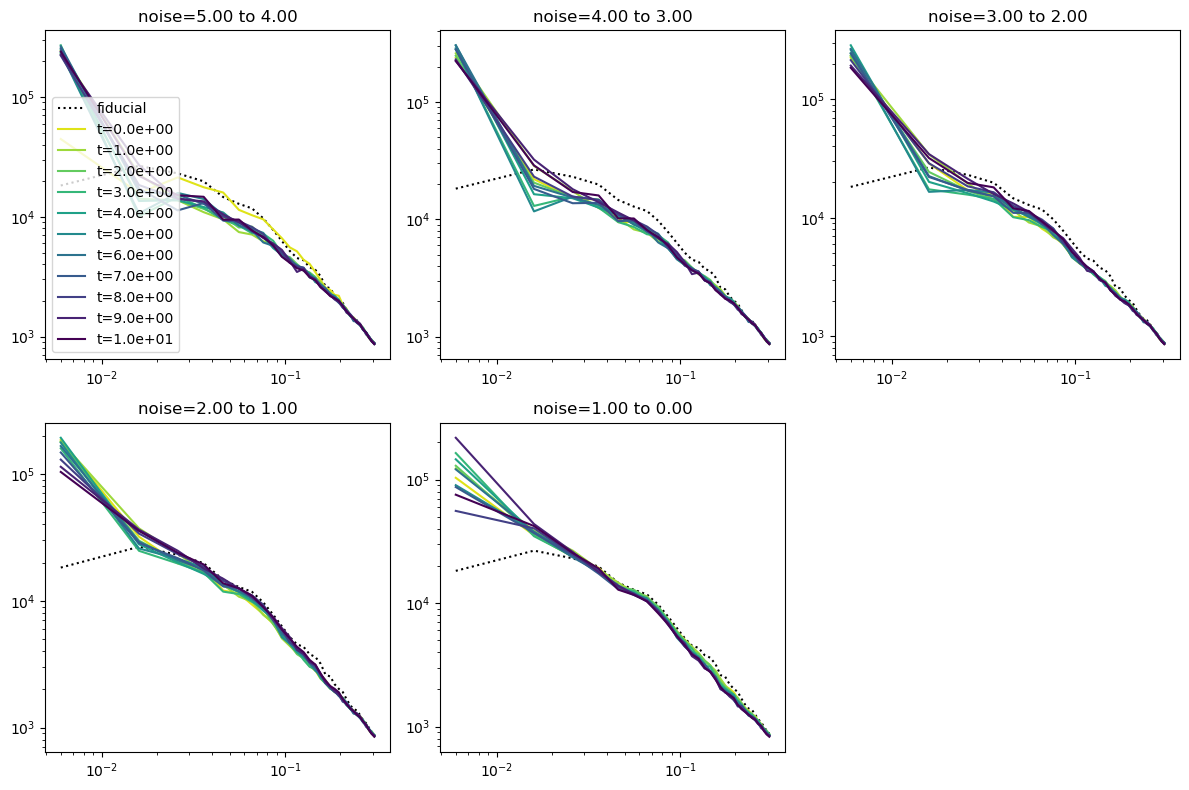

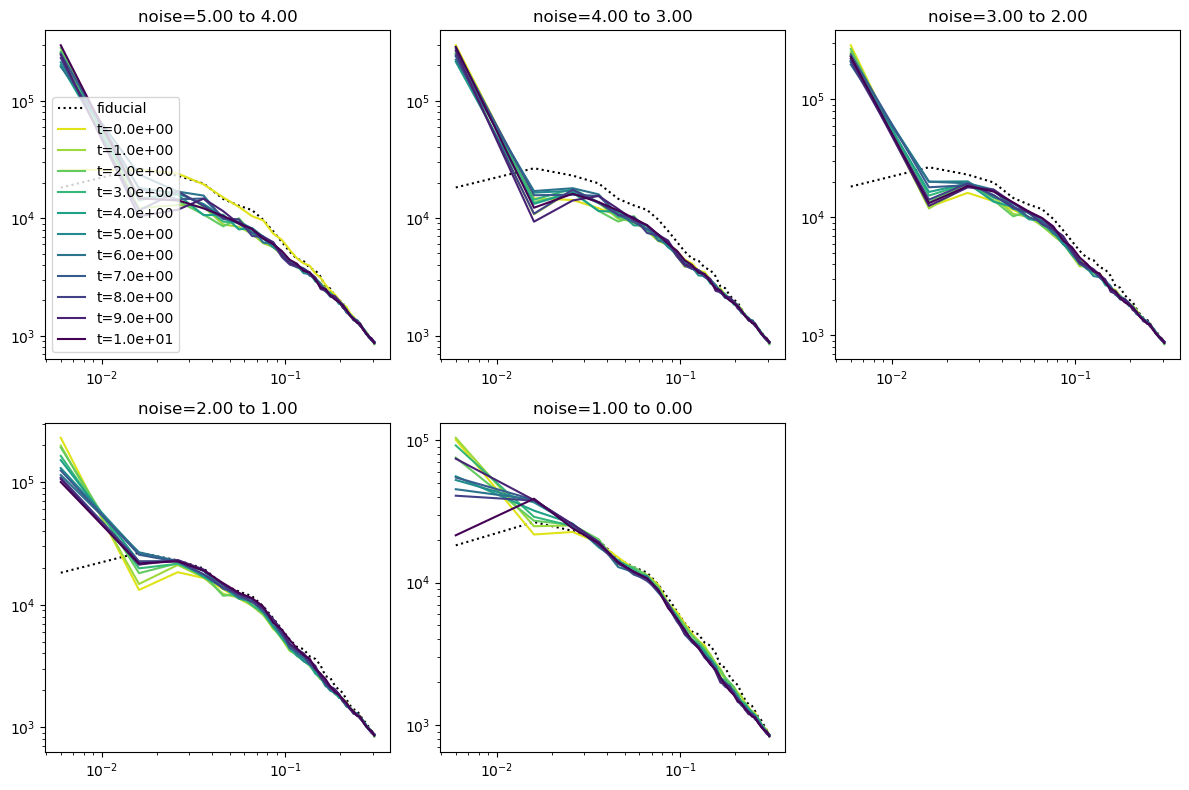

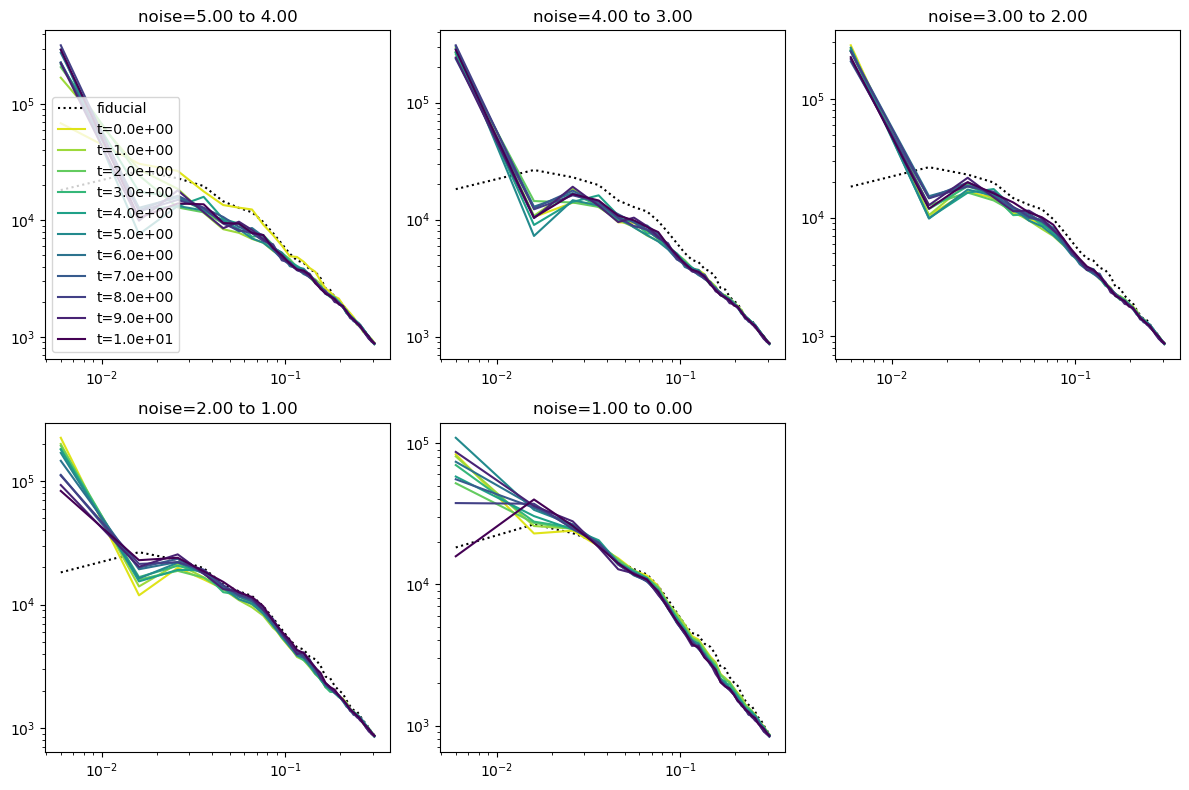

In [7]:
# plot_fn = lambda pk, *args, **kwargs: plt.plot(pk_init[0], pk_init[0]*pk, *args, **kwargs)
plot_pk = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[1], *args, **kwargs)
n_cols = int(np.ceil(len(noises)/3))

for i_sample in range(n_samples):
    plt.figure(figsize=(3*4, n_cols*4))
    # for i_noise, noise in enumerate(noises):
    for i_noise, (noise0, noise1) in enumerate(pairwise(noises)):
        plt.subplot(n_cols, 3, i_noise+1)
        colors = plt.get_cmap('viridis')(np.linspace(0,.95,len(ts)))[::-1]
        plt.gca().set_prop_cycle(color=colors)
        plot_pk(pk_init, 'k:', label="fiducial")
        for i_time, time in enumerate(ts):
            plot_pk(pks[i_sample, i_noise, i_time, :, :], label=f"t={time:.1e}")
        if i_noise==0:plt.legend()
        # plt.title(f"noise={noise:.2f}")
        plt.title(f"noise={noise0:.2f} to {noise1:.2f}")
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), f"pk0_to_pk0_lin_{len(noises)}_{i_sample}.svg")
    plt.show()

In [8]:
from matplotlib import animation, rc
rc('animation', html='html5')
xx, yy = np.mgrid[[slice(0,box_l,mesh_l*1j) 
                for mesh_l,box_l in zip(config['mesh_size'][:-1],config['box_size'][:-1])]]
i_sample = 0
proj_meshes = meshes[:,:-1].reshape((n_samples, -1, *config['mesh_size'])).mean(axis=-1)[i_sample]
residual_meshes = (proj_meshes - fiduc_params['init_mesh'].mean(axis=-1))**2

plt.figure(figsize=(lambda h:(2*h*7/6,h))(4)) # compensate for colorbars
plot_mesh = lambda meshes: plt.pcolormesh(xx, yy, meshes[0], 
                                        vmin=np.quantile(meshes, .01), 
                                        vmax=np.quantile(meshes, .99))
plt.subplot(121)
quad1 = plot_mesh(proj_meshes)
plt.xlabel("x (Mpc/h)"), plt.ylabel("y (Mpc/h)")
plt.title("init. cond. sampling")
plt.colorbar()
plt.subplot(122)
quad2 = plot_mesh(residual_meshes)
plt.xlabel("x (Mpc/h)"), plt.ylabel("y (Mpc/h)")
plt.title("square error")
plt.colorbar()
plt.tight_layout()

def update(i):
    quad1.set_array(proj_meshes[i])
    quad2.set_array(residual_meshes[i])

anim = animation.FuncAnimation(plt.gcf(), update, frames=len(proj_meshes), interval=100)
plt.close()
video_name = "pk0_to_pk0_lin_meshes.mp4"
anim.save(video_name)
mlflow.log_artifact(video_name)
display(anim)

### $P_0(k)$ to $P_1(k)$

In [ ]:
mlflow.end_run()
mlflow.start_run(run_name="Pk0-1 conv strict + anim")
# mlflow.start_run(run_id="")
mlflow.log_params(config)
mlflow.log_params({'n_samples':n_samples,'t0':t0,'t1':t1,'dt0':dt0})

from montecosmo.models import get_pk_fn, get_init_mesh_fn
pk_init = get_pk_fn(config)(fiduc_params['init_mesh'])
pk_vfn = vmap(get_pk_fn(config))
init_mesh_vfn = vmap(get_init_mesh_fn(config))

In [48]:
# Recondition model on new observable
fiduc_params2 = dict(fiduc_params, sigma8_=0)
obs_params2 = {name: fiduc_params2[name] for name in obs_names}
score_fn2 = get_score_fn(condition(model, obs_params2))
pk_init2 = get_pk_fn(config)(get_init_mesh_fn(config)(**fiduc_params2)[1])

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


In [49]:
from itertools import pairwise
current_params = dict(init_params)
params_ = tree_map(lambda x: jnp.broadcast_to(x, (n_samples,*jnp.shape(x))), obs_params2)
params_.pop('obs_mesh') # won't need it
noises = jnp.linspace(0,5,6)[::-1]
pks2 = np.zeros((n_samples, len(noises), len(ts), *pk_init.shape))
meshes2 = np.zeros((n_samples, len(noises), len(ts), *config['mesh_size']))

mlflow.log_metric('halt',0)
for i_noise, noise in enumerate(noises):
    noise_fn = lambda t: noise
    print(f"noise = {noise_fn(t0):.2f}. step = {i_noise+1}/{len(noises)}")
# for i_noise, (noise0, noise1) in enumerate(pairwise(noises)):
#     noise_fn = lambda t: (noise0-noise1)*(t-t1)/(t0-t1) + noise1
#     print(f"noise goes from {noise_fn(t0):.2f} to {noise_fn(t1):.2f}. step = {i_noise+1}/{len(noises)}")
    
    run_langevin = get_run_langevin(t0, t1, dt0, ts, score_fn2, noise_fn, shape_struct)
    run = run_langevin(current_params, jr.split(diffeq_key, n_samples))
    current_params = tree_map(lambda x: x[:,-1], run)
    for i_time in range(len(ts)):
        _, init_mesh = init_mesh_vfn(**dict(params_, init_mesh_=run['init_mesh_'][:, i_time]))
        meshes2[:, i_noise, i_time] = init_mesh
        pks2[:, i_noise, i_time] = pk_vfn(init_mesh)
mlflow.log_metric('halt',1), mlflow.log_metric('halt',0);

noise = 5.00. step = 1/6
noise = 4.00. step = 2/6
noise = 3.00. step = 3/6
noise = 2.00. step = 4/6
noise = 1.00. step = 5/6


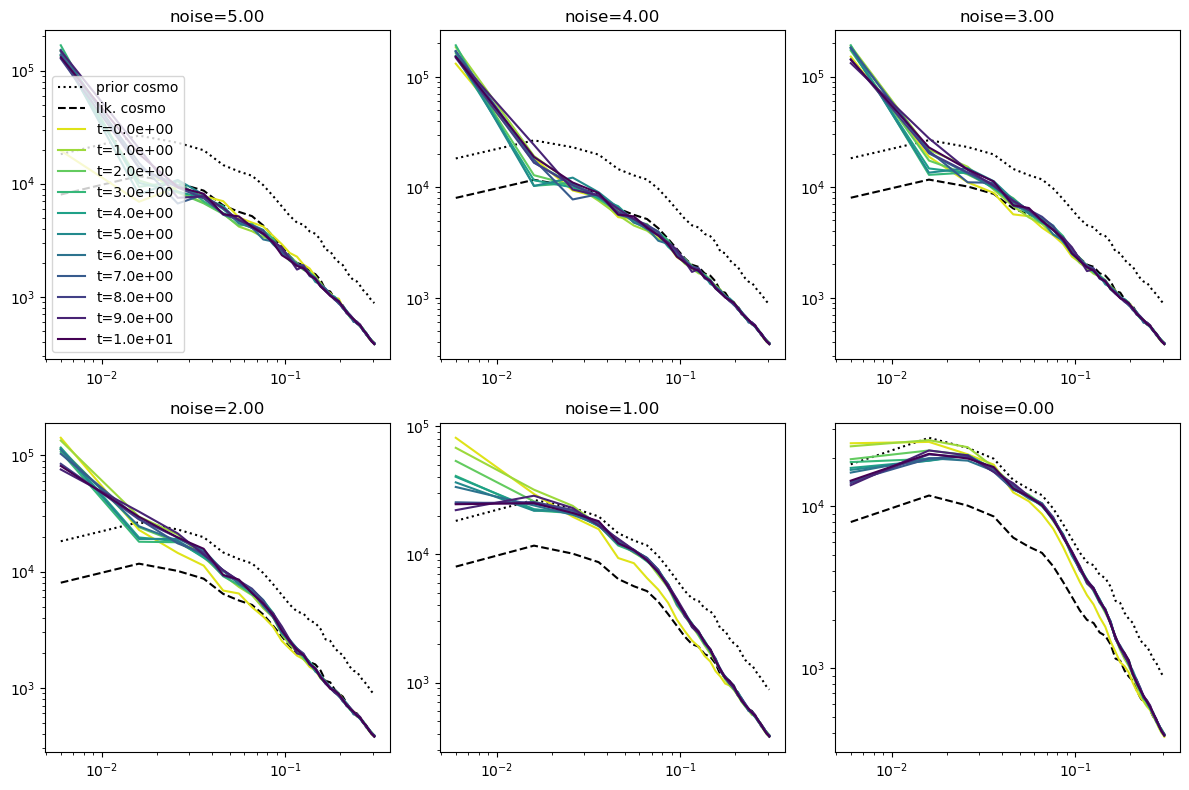

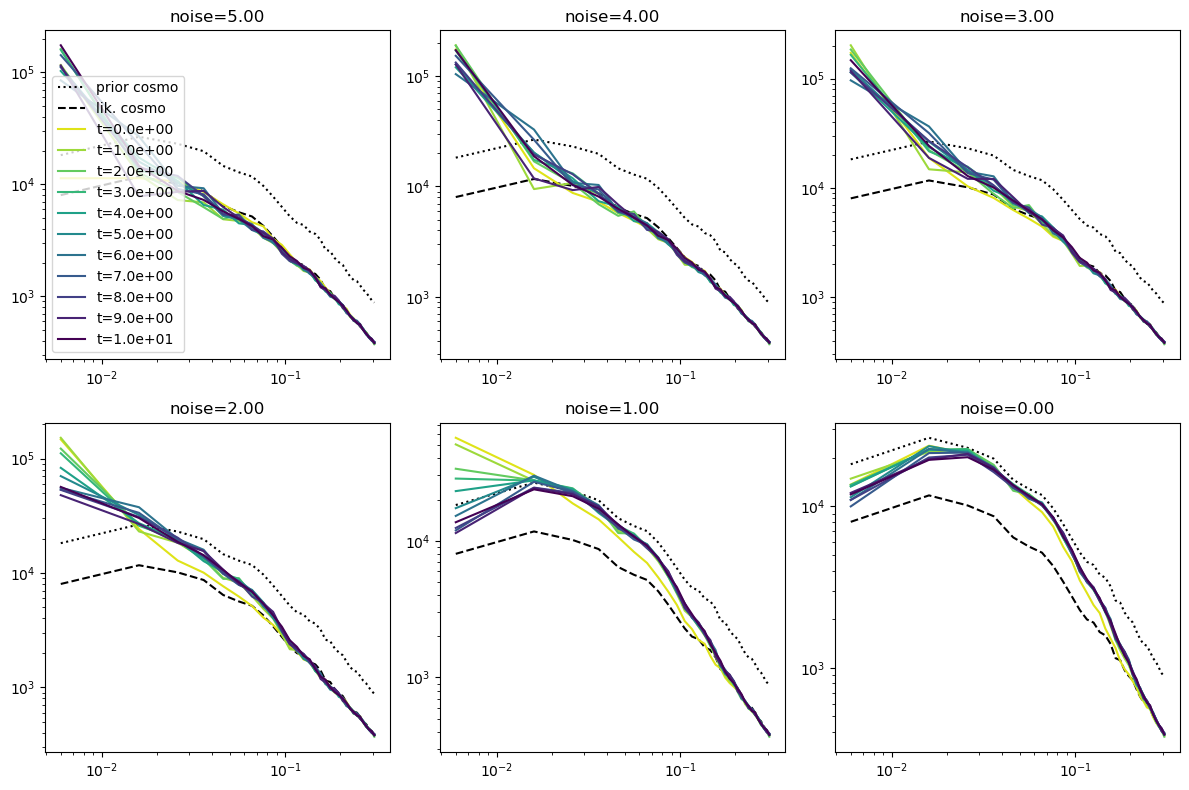

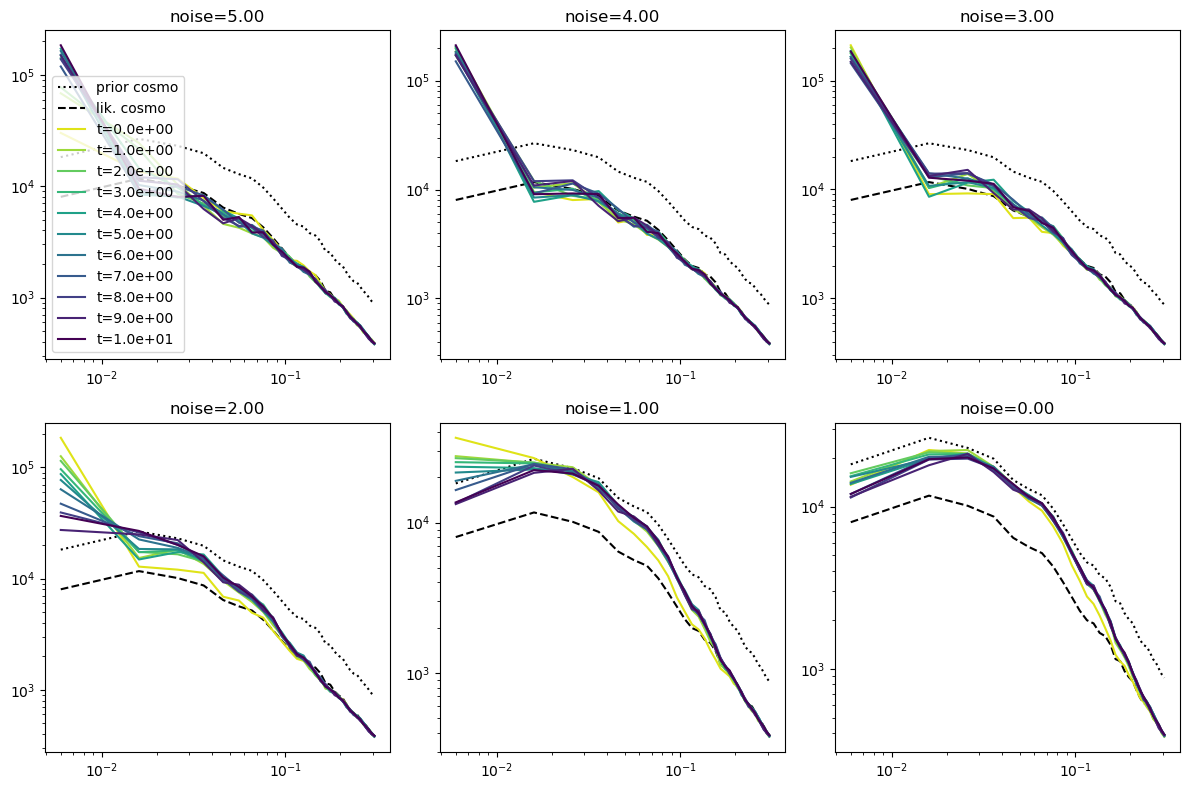

In [ ]:
plot_pk = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[1], *args, **kwargs)
n_cols = int(np.ceil(len(noises)/3))

for i_sample in range(n_samples):
    plt.figure(figsize=(3*4, n_cols*4))
    for i_noise, noise in enumerate(noises):
    # for i_noise, (noise0, noise1) in enumerate(pairwise(noises)):
        plt.subplot(n_cols, 3, i_noise+1)
        colors = plt.get_cmap('viridis')(np.linspace(0,.95,len(ts)))[::-1]
        plt.gca().set_prop_cycle(color=colors)
        plot_pk(pk_init, 'k:', label="prior cosmo")
        plot_pk(pk_init2, 'k--', label="lik. cosmo")
        for i_time, time in enumerate(ts):
            plot_pk(pks2[i_sample, i_noise, i_time], label=f"t={time:.1e}")
        if i_noise==0:plt.legend()
        plt.title(f"noise={noise:.2f}")
        # plt.title(f"noise={noise0:.2f} to {noise1:.2f}")
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), f"pk0_to_pk0_step_{len(noises)}_{i_sample}.svg")
    plt.show()

In [ ]:
from matplotlib import animation, rc
rc('animation', html='html5')
xx, yy = np.mgrid[[slice(0,box_l,mesh_l*1j) 
                for mesh_l,box_l in zip(config['mesh_size'][:-1],config['box_size'][:-1])]]
i_sample = 0
proj_meshes = meshes2[i_sample].reshape((-1, *config['mesh_size'])).mean(axis=-1)
residual_meshes = (proj_meshes - fiduc_params2['init_mesh'].mean(axis=-1))**2
mses = residual_meshes.mean(axis=(-1,-2))

n_lines = 10
colors = plt.get_cmap('viridis')(np.linspace(0,.95,n_lines))[::-1]
pk_traj = pks2[i_sample].reshape((-1, *pk_init.shape))
noises_title = np.repeat(noises, len(ts))

plt.figure(figsize=(lambda h:(2*h*7/6,2*h))(4)) # compensate for colorbars
plot_mesh = lambda meshes: plt.pcolormesh(xx, yy, meshes[0], 
                                        vmin=np.quantile(meshes, .01), 
                                        vmax=np.quantile(meshes, .99))
plot_pk = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[1], *args, **kwargs)

plt.subplot(221)
quad1 = plot_mesh(proj_meshes)
plt.xlabel("x (Mpc/h)"), plt.ylabel("y (Mpc/h)")
plt.title("init. cond. sampling")
plt.colorbar()

plt.subplot(222)
quad2 = plot_mesh(residual_meshes)
plt.xlabel("x (Mpc/h)"), plt.ylabel("y (Mpc/h)")
plt.title("square error")
plt.colorbar()

plt.subplot(223)
line1 = plt.plot(mses[0])[0]
plt.xlim(0, len(residual_meshes))
ymin, ymax = np.quantile(mses, .01), np.quantile(mses, .99)
ymean, ydiff = (ymax+ymin)/2, 1.2*(ymax-ymin)/2
plt.ylim(ymean-ydiff, ymean+ydiff)
plt.grid()
plt.xlabel("steps"), plt.ylabel("MSE")

plt.subplot(224)
plt.gca().set_prop_cycle(color=colors)
plot_pk(pk_init, 'k:', label="prior cosmo")
plot_pk(pk_init2, 'k--', label="lik. cosmo")
lines = plot_pk(pk_traj[0:n_lines].transpose(1,2,0))
title = plt.title(f"noise={noises[0]:.2f}")
plt.grid(), plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$P(k)$ [(Mpc/h)$^3$]")
plt.tight_layout()

def update(i):
    quad1.set_array(proj_meshes[i])
    quad2.set_array(residual_meshes[i])
    line1.set_data(range(i), mses[:i])

    for i_line, line in enumerate(lines):
        if i+i_line < len(pk_traj):
            line.set_data(pk_traj[i+i_line,0], pk_traj[i+i_line,1])
        else:
            line.set_data([],[])
        title.set_text(f"noise={noises_title[i]:.2f}")
    return quad1, quad2, line1, *lines, title

anim = animation.FuncAnimation(plt.gcf(), update, frames=len(proj_meshes), interval=100, blit=True)
plt.close()
video_name = "pk00_step_anim.mp4"
anim.save(video_name)
mlflow.log_artifact(video_name)
display(anim)

## Samples analysis

In [ ]:
def plot_cosmo_contours(samples_list, samples_labels, samples_colors, cosmo_names, cosmo_labels, fiduc_cosmo_params):
    if samples_colors is None:
        samples_colors = [{'color':'b', 'alpha':0.3},{'color':'r'}]
    # Triangle plot
    samples_gds = []
    for samples in samples_list:
        samples_arr = np.array(list(samples.values())).T
        samples_gds.append(MCSamples(samples=samples_arr, names=cosmo_names, labels=cosmo_labels))
    gd = plots.get_subplot_plotter(subplot_size=None)
    # gd.settings.solid_colors='tab10_r'
    gd.triangle_plot(roots=samples_gds,
                    markers=fiduc_cosmo_params,
                    filled=True, 
                    legend_labels=samples_labels,
                    line_args=samples_colors,
                    contour_args=samples_colors,)

def plot_summary_table(samples, labels):
    # Plot summary table
    summary_dic = numpyro.diagnostics.summary(samples, group_by_chain=False) # NOTE: group_by_chain if several chains
    summary_arr = [list(list(summary_dic.values())[i].values()) for i in range(len(summary_dic.values()))]

    # Define a custom formatting function to vectorize on summary array
    def format_value(value):
        return f"{value:0.2f}"

    plt.subplot(position=[0,0,1,1]), plt.axis('off')
    # gd.fig.axes[-1]('tight'), plt.axis('tight'), plt.subplots_adjust(top=2), plt.gcf().patch.set_visible(False), 
    plt.table(cellText=np.vectorize(format_value)(summary_arr),
                # rowLabels=list(summary_dic.keys()),
                rowLabels=["$"+label+"$" for label in labels], 
                colLabels=list(list(summary_dic.values())[0].keys()),)